In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import context

In [3]:
from IPython.display import display

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [5]:
import os
import pickle
import numpy as np
from datetime import datetime

In [6]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Compose
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

In [7]:
from bestiary.criteria.autoencoder import AutoEncoderLoss

In [8]:
from bestiary.nets.wgan import WassersteinGenerativeAdversarialNet

In [9]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint, ProgressBar, Callback
from skorch.callbacks import TensorBoard, BatchScoring, EpochScoring, PassthroughScoring, LRScheduler

In [10]:
import matplotlib.pyplot as plt

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from tensorboardX import SummaryWriter

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [13]:
from sklearn.datasets import fetch_openml

In [14]:
from skopt import BayesSearchCV

In [15]:
from scipy.stats import loguniform, randint

In [16]:
from bestiary.modules.measures.gan import Generator, Discriminator

# Data

In [17]:
mnist = MNIST('data', download=True, transform=Compose([ToTensor(), Lambda(lambda x: x.reshape(-1))]))

In [18]:
class MyTensorBoard(TensorBoard):
    transform = ToPILImage()
        
    def __init__(self, n=9, latent_dim=16, every=20, path='', *args, **kwargs):
        
        super(MyTensorBoard, self).__init__(*args, **kwargs)
        
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        self.n = n
        self.grid = torch.randn(n ** 2, latent_dim)
        self.path = path
        
        self.batch = 0
        self.i = 1
        self.every = every
        
    def generate_image(self, net):
        generated_grid = net.module_(self.grid).view(-1, 1, 28, 28)
        image = make_grid(generated_grid, nrow=self.n)
        return image
    
    def on_batch_end(self, net, X, y, training, **kwargs):
        
        if self.path and training:
        
            if self.batch % self.every == 0:
                image = self.generate_image(net)
                to_pil_image(image).save(f'{self.path}generated_{self.i:04}.jpg')
                self.i += 1
        
        self.batch += 1
    
    def on_epoch_end(self, net, **kwargs):
        image = self.generate_image(net)
        epoch = net.history[-1, 'epoch']
        self.writer.add_image('generated', image, global_step=epoch)
        super().on_epoch_end(net, **kwargs)

# WGAN

In [19]:
wgan = WassersteinGenerativeAdversarialNet(
    module=Generator,
    critic=Discriminator,
    iterator_train__shuffle=True,
    train_generator_every=5,
    module__latent_dim=16,
    module__hidden_dim=256,
    module__n_layers=3,
    critic__hidden_dim=256,
    critic__n_layers=3,
    optimizer=torch.optim.Adam,
    critic_optimizer=torch.optim.Adam,
    lr=1e-3,
    max_epochs=200,
    verbose=1,
    warm_start=True,
    callbacks=[
        ('early_stopping', EarlyStopping(monitor='valid_distance', patience=6)),
        ('tensorboard', MyTensorBoard(n=9, latent_dim=16, every=20, path='images2/', writer=SummaryWriter('logs/WGAN')))
    ]
)

In [42]:
wgan.fit(mnist, epochs=10)

     69        -0.6269           -0.0192            0.7139            0.5845  17.7558
     70        -0.6263           -0.0099            0.7126            0.6778  18.3742
     71        -0.6213           -0.0106            0.7087            0.6630  18.3801
     72        -0.6170            0.0167            0.7079            0.7093  18.5820
     73        -0.6156           -0.0476            0.7030            0.5773  19.9292
     74        -0.5960            0.0056            0.6836            0.5226  19.3998
     75        -0.5883            0.0470            0.6759            0.6171  19.9575
     76        -0.5985            0.0452            0.6843            0.5917  20.2418
     77        -0.5911            0.0050            0.6749            0.6442  19.6763
     78        -0.5785           -0.0157            0.6627            0.5674  19.7303


<class 'bestiary.nets.wgan.WassersteinGenerativeAdversarialNet'>[initialized](
  module_=Generator(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=256, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
      )
      (3): Linear(in_features=256, out_features=784, bias=True)
      (4): Sigmoid()
    )
  ),
)

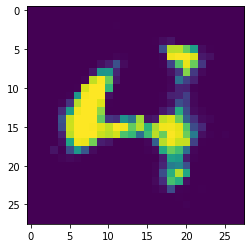

In [21]:
plt.imshow(wgan.generate(1).reshape(28, 28))

# GAN

In [53]:
gan = GenerativeAdversarialNet(
    module=Generator,
    critic=Discriminator,
    iterator_train__shuffle=True,
    train_generator_every=2,
    module__latent_dim=8,
    module__hidden_dim=128,
    module__n_layers=2,
    critic__hidden_dim=128,
    critic__n_layers=2,
    optimizer=torch.optim.Adam,
    critic_optimizer=torch.optim.Adam,
    critic_optimizer__lr=1e-5,
    lr=1e-4,
    max_epochs=50,
    verbose=1,
    warm_start=True,
    callbacks=[
        ('tensorboard', MyTensorBoard(
            writer=SummaryWriter(f'logs/{datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")}'),
            path='images_gan/',
            latent_dim=8,
        )),
        ('early_stopping', EarlyStopping(monitor='valid_distance', patience=30)),
    ]
)

In [57]:
gan.fit(mnist)

      8         0.6751           -0.0110            0.0215            0.1297  8.5298
      9         0.6365           -0.0094            0.0597            0.0448  9.3608
     10         0.6458           -0.0073            0.0505            0.0161  9.7381
     11         0.5584           -0.0275            0.1384            0.0579  9.4225
     12         0.5998           -0.0447            0.0977            0.1229  8.8572
     13         0.6211           -0.0232            0.0762            0.0899  8.7454
     14         0.6335           -0.0216            0.0633            0.0419  8.9639
     15         0.6362           -0.0172            0.0610            0.0791  9.0628
     16         0.6070           -0.0354            0.0899            0.1202  8.6911
     17         0.5566           -0.0574            0.1414            0.1685  8.8680
     18         0.5299           -0.1146            0.1689            0.2201  8.9914
     19         0.5407           -0.1174            0.1598       

<class 'bestiary.nets.wgan.GenerativeAdversarialNet'>[initialized](
  module_=Generator(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
          (2): ReLU()
        )
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
      (4): Sigmoid()
    )
  ),
)

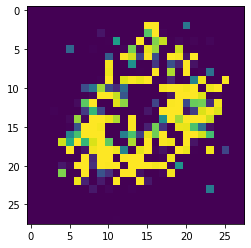

In [70]:
plt.imshow(gan.generate(1).reshape(28, 28))

In [77]:
with open('wgan.pkl', 'wb') as f:
    pickle.dump(wgan, f)

/Users/basile/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [30]:
wgan.train_generator_every = 3

In [31]:
wgan.fit(mnist)

     31        -0.9498      1.0536            0.9889  23.7151
     32        -0.8374      0.9349            0.8770  24.3554
     33        -0.7812      0.8772            0.8207  23.4238
     34        -0.7664      0.8652            0.8068  23.5074
     35        -0.7454      0.8376            0.7841  23.2464
     36        -0.7460      0.8278            0.7826  23.8969


<class 'bestiary.nets.wgan.WassersteinGenerativeAdversarialNet'>[initialized](
  module_=Generator(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=256, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
        (2): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Linear(in_features=256, out_features=256, bias=True)
          (2): ReLU()
        )
      )
      (3): Linear(in_features=256, out_features=784, bias=True)
      (4): Sigmoid()
    )
  ),
)

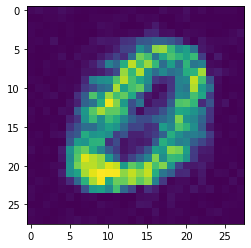

In [39]:
plt.imshow(wgan.generate(1).reshape(28, 28))

In [94]:
wgan.save_params(
    f_params='wgan_params.pkl',
    f_optimizer='wgan_optimizer.pkl',
    f_history='wgan_history.json',
)

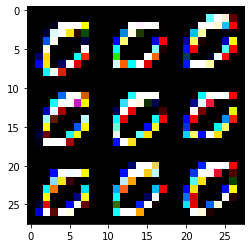

In [86]:
plt.imshow(wgan.predict(torch.zeros((3, 16))))

In [77]:
np.zeros((1, 16)).astype(np.float64)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])